# SC4002 Assignment - Master Notebook (Part 0 & 1) - MODERN VERSION

**Team 3 (Aaron & Javier)**

This notebook contains all the foundational code for Part 0 and Part 1, **updated for modern PyTorch/torchtext**.

1.  **Part 0:** Sets up the environment, loads the `TREC` dataset, and splits it into 80/20 Train/Validation sets.
2.  **Part 1:** Builds the vocabulary, loads GloVe embeddings, analyzes OOV words, implements an OOV strategy, and generates the t-SNE plot.

**Key Changes from Original:**
- Uses modern PyTorch 2.4+ and compatible libraries
- Replaces deprecated `torchtext.data` API with `torch.utils.data`
- Manual TREC dataset loading (dataset no longer in torchtext)
- Uses `DataLoader` instead of `BucketIterator`

## Environment Setup

**Recommended Setup (using uv - fast!):**

```bash
# 1. Create virtual environment with Python 3.11
uv venv --python 3.11
source .venv/bin/activate

# 2. Install packages
uv pip install torch==2.4.1 'numpy<2.0' scikit-learn matplotlib jupyter notebook ipykernel nltk spacy

# 3. Download spacy model
python -m spacy download en_core_web_sm

# 4. Download NLTK data
python -c "import nltk; nltk.download('stopwords')"
```

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import random
import warnings
import spacy
import urllib.request
import os

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print(f"PyTorch Version: {torch.__version__}")
print(f"NumPy Version: {np.__version__}")

# Define the 6 topic labels for the TREC dataset
TREC_LABELS = {
    'ABBR': 0,  # Abbreviation
    'ENTY': 1,  # Entity
    'DESC': 2,  # Description
    'HUM': 3,   # Human
    'LOC': 4,   # Location
    'NUM': 5    # Numeric
}
LABEL_NAMES = list(TREC_LABELS.keys())
print(f"Label mapping: {TREC_LABELS}")

PyTorch Version: 2.4.1
NumPy Version: 1.26.4
Label mapping: {'ABBR': 0, 'ENTY': 1, 'DESC': 2, 'HUM': 3, 'LOC': 4, 'NUM': 5}


## Part 0: Dataset Preparation

Load the `TREC` dataset and split the provided `train_data` into an 80% training set and a 20% validation set.

In [2]:
# Download TREC dataset if not already present
def download_trec_data():
    """Download TREC dataset files from a reliable source."""
    os.makedirs('.data', exist_ok=True)
    
    files = {
        'train': '.data/TREC_train.txt',
        'test': '.data/TREC_test.txt'
    }
    
    urls = {
        'train': 'https://cogcomp.seas.upenn.edu/Data/QA/QC/train_5500.label',
        'test': 'https://cogcomp.seas.upenn.edu/Data/QA/QC/TREC_10.label'
    }
    
    for key, filepath in files.items():
        if not os.path.exists(filepath):
            print(f"Downloading {key} data...")
            try:
                urllib.request.urlretrieve(urls[key], filepath)
                print(f"  ✓ Downloaded to {filepath}")
            except Exception as e:
                print(f"  ✗ Error downloading {key}: {e}")
                print(f"  Please manually download from {urls[key]}")
                print(f"  and save as {filepath}")
        else:
            print(f"  ✓ {key} data already exists")
    
    return files['train'], files['test']

# Load TREC dataset
def load_trec_file(filepath):
    """Load TREC dataset from file."""
    examples = []
    with open(filepath, 'r', encoding='latin-1') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # Format: LABEL:sublabel text of question
            label, text = line.split(' ', 1)
            # Extract coarse label (e.g., 'DESC' from 'DESC:def')
            coarse_label = label.split(':')[0]
            examples.append({'text': text, 'label': coarse_label})
    return examples

# Download and load data
train_file, test_file = download_trec_data()
train_examples = load_trec_file(train_file)
test_examples = load_trec_file(test_file)

print(f"\nLoaded {len(train_examples)} training examples")
print(f"Loaded {len(test_examples)} test examples")
print(f"\nSample example: {train_examples[0]}")

  ✓ Downloaded to .data/TREC_train.txt
  ✓ Downloaded to .data/TREC_train.txt
  ✓ Downloaded to .data/TREC_test.txt

Loaded 5452 training examples
Loaded 500 test examples

Sample example: {'text': 'How did serfdom develop in and then leave Russia ?', 'label': 'DESC'}
  ✓ Downloaded to .data/TREC_test.txt

Loaded 5452 training examples
Loaded 500 test examples

Sample example: {'text': 'How did serfdom develop in and then leave Russia ?', 'label': 'DESC'}


In [3]:
# Initialize spacy tokenizer
print("Loading spacy tokenizer...")
try:
    nlp = spacy.load('en_core_web_sm')
    print("  ✓ Spacy model loaded")
except:
    print("  ✗ Spacy model not found. Run: python -m spacy download en_core_web_sm")
    raise

def tokenize(text):
    """Tokenize text using spacy."""
    return [token.text.lower() for token in nlp(text)]

# Tokenize all examples
print("\nTokenizing examples...")
for example in train_examples + test_examples:
    example['tokens'] = tokenize(example['text'])

print(f"Sample tokenized: {train_examples[0]['tokens'][:10]}...")

Loading spacy tokenizer...
  ✓ Spacy model loaded

Tokenizing examples...
  ✓ Spacy model loaded

Tokenizing examples...
Sample tokenized: ['how', 'did', 'serfdom', 'develop', 'in', 'and', 'then', 'leave', 'russia', '?']...
Sample tokenized: ['how', 'did', 'serfdom', 'develop', 'in', 'and', 'then', 'leave', 'russia', '?']...


In [4]:
# Split train data into 80% train, 20% validation
# Stratified split to maintain label distribution
from collections import defaultdict

# Group by label
label_groups = defaultdict(list)
for example in train_examples:
    label_groups[example['label']].append(example)

# Split each group 80/20
train_split = []
valid_split = []

for label, examples in label_groups.items():
    random.shuffle(examples)
    split_idx = int(0.8 * len(examples))
    train_split.extend(examples[:split_idx])
    valid_split.extend(examples[split_idx:])

# Shuffle the splits
random.shuffle(train_split)
random.shuffle(valid_split)

print(f"--- (Part 0) Data Splits ---")
print(f"Training set size: {len(train_split)}")
print(f"Validation set size: {len(valid_split)}")
print(f"Test set size: {len(test_examples)}")

# Verify label distribution
for split_name, split_data in [('Train', train_split), ('Valid', valid_split), ('Test', test_examples)]:
    label_counts = Counter([ex['label'] for ex in split_data])
    print(f"\n{split_name} label distribution:")
    for label in LABEL_NAMES:
        print(f"  {label}: {label_counts[label]}")

--- (Part 0) Data Splits ---
Training set size: 4359
Validation set size: 1093
Test set size: 500

Train label distribution:
  ABBR: 68
  ENTY: 1000
  DESC: 929
  HUM: 978
  LOC: 668
  NUM: 716

Valid label distribution:
  ABBR: 18
  ENTY: 250
  DESC: 233
  HUM: 245
  LOC: 167
  NUM: 180

Test label distribution:
  ABBR: 9
  ENTY: 94
  DESC: 138
  HUM: 65
  LOC: 81
  NUM: 113


In [5]:
# Build vocabulary from training data
print("\nBuilding vocabulary from training data...")

# Count word frequencies
word_freq = Counter()
for example in train_split:
    word_freq.update(example['tokens'])

# Create vocabulary (words with min_freq=1)
MIN_FREQ = 1
vocab_words = ['<unk>', '<pad>'] + [word for word, freq in word_freq.items() if freq >= MIN_FREQ]

# Create word to index mapping
word2idx = {word: idx for idx, word in enumerate(vocab_words)}
idx2word = {idx: word for word, idx in word2idx.items()}

print(f"(Answer Q1a) Vocabulary size: {len(vocab_words)}")
print(f"Most common words: {word_freq.most_common(20)}")

# Special tokens
UNK_IDX = word2idx['<unk>']
PAD_IDX = word2idx['<pad>']


Building vocabulary from training data...
(Answer Q1a) Vocabulary size: 7454
Most common words: [('?', 4282), ('the', 3040), ('what', 2689), ('is', 1356), ('of', 1245), ('in', 977), ('a', 824), ('`', 684), ('how', 619), ("'s", 573), ('was', 521), ('to', 514), ('who', 508), (',', 441), ('are', 361), ('for', 359), ('and', 332), ("''", 328), ('does', 318), ('did', 311)]


## Part 1: Word Embeddings & Analysis

In [6]:
# Load GloVe vectors
print("Loading GloVe vectors...")
print("(This may take a minute on first run - downloading 822MB file)\n")

import zipfile
import urllib.request

# Download GloVe if needed
glove_dir = '.vector_cache'
os.makedirs(glove_dir, exist_ok=True)
glove_file = os.path.join(glove_dir, 'glove.6B.300d.txt')
glove_zip = os.path.join(glove_dir, 'glove.6B.zip')

if not os.path.exists(glove_file):
    if not os.path.exists(glove_zip):
        print("Downloading GloVe 6B.300d vectors...")
        url = 'https://nlp.stanford.edu/data/glove.6B.zip'
        urllib.request.urlretrieve(url, glove_zip)
        print("  ✓ Downloaded")
    
    print("Extracting GloVe vectors...")
    with zipfile.ZipFile(glove_zip, 'r') as zip_ref:
        zip_ref.extract('glove.6B.300d.txt', glove_dir)
    print("  ✓ Extracted")

# Load GloVe vectors
print("Loading GloVe vectors into memory...")
glove_vectors = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        glove_vectors[word] = vector

print(f"  ✓ Loaded {len(glove_vectors)} GloVe vectors")
print(f"  Vector dimension: {len(next(iter(glove_vectors.values())))}")

Loading GloVe vectors...
(This may take a minute on first run - downloading 822MB file)

  ✓ Downloaded
Extracting GloVe vectors...
  ✓ Downloaded
Extracting GloVe vectors...
  ✓ Extracted
Loading GloVe vectors into memory...
  ✓ Extracted
Loading GloVe vectors into memory...
  ✓ Loaded 400000 GloVe vectors
  Vector dimension: 300
  ✓ Loaded 400000 GloVe vectors
  Vector dimension: 300


In [7]:
# Create embedding matrix
# (Answer Q1c) OOV Strategy: Use GloVe for known words, random initialization for OOV
print("\nCreating embedding matrix...")
EMBED_DIM = 300

# Initialize with random normal distribution (mean=0, std=1)
embedding_matrix = np.random.randn(len(vocab_words), EMBED_DIM).astype('float32')

# Replace with GloVe vectors where available
oov_words = []
glove_found = 0

for word, idx in word2idx.items():
    if word in glove_vectors:
        embedding_matrix[idx] = glove_vectors[word]
        glove_found += 1
    else:
        oov_words.append(word)

# Set padding vector to zeros
embedding_matrix[PAD_IDX] = np.zeros(EMBED_DIM)

print(f"  ✓ Created embedding matrix: {embedding_matrix.shape}")
print(f"  Words with GloVe vectors: {glove_found}/{len(vocab_words)}")
print(f"  (Answer Q1b) OOV words: {len(oov_words)}/{len(vocab_words)}")
print(f"\nFirst 50 OOV words: {oov_words[1:51]}")


Creating embedding matrix...
  ✓ Created embedding matrix: (7454, 300)
  Words with GloVe vectors: 7273/7454
  (Answer Q1b) OOV words: 181/7454

First 50 OOV words: ['<pad>', 'respones', 'madilyn', 'rednitz', 'cabarnet', 'plumbism', 'verdandi', 'jogis', 'spicey', 'slotbacks', 'circumorbital', 'deltiologist', 'spermologer', 'hendecasyllabic', 'cullions', 'phobophobe', 'deveopment', 'flintknapping', 'vbp', 'short-', 'siphnos', 'seriphos', 'g.m.t.', 'ballcock', 'resurrectionist', 'win-', 'svhs', 'pothooks', 'pregnacy', 'baseemen', 'shiest', 'foot-9', 'batcycle', 'contibution', 'palmiped', 'ouarterly', 'f25', 'mandibulofacial', 'dysostosis', 'zoonose', 'circumnavigator', 'spritsail', '12601', '2th', 'pencey', 'cullion', 'lavoir', 'v.9', 'winkerbean', 'carefreeness']


In [8]:
# (Answer Q1b) OOV words per topic
print("\n(Answer Q1b) Unique OOV words per topic:")

oov_set = set(oov_words)
oov_by_topic = defaultdict(set)
token_counts_by_topic = defaultdict(Counter)

for example in train_split:
    topic_name = example['label']
    
    # Filter tokens: only alphabetic words
    filtered_tokens = [token for token in example['tokens'] if token.isalpha()]
    token_counts_by_topic[topic_name].update(filtered_tokens)
    
    # Track OOV words
    for token in filtered_tokens:
        if token in oov_set:
            oov_by_topic[topic_name].add(token)

for topic_name in sorted(LABEL_NAMES):
    print(f"  {topic_name}: {len(oov_by_topic[topic_name])}")


(Answer Q1b) Unique OOV words per topic:
  ABBR: 2
  DESC: 53
  ENTY: 44
  HUM: 26
  LOC: 14
  NUM: 15


### (Answer Q1c) OOV Strategy Proposal

Our strategy is to build a custom embedding matrix that leverages pre-trained GloVe vectors while also handling Out-of-Vocabulary (OOV) words:

1. **Initialize embedding matrix**: Create a matrix of shape `(vocab_size, 300)` initialized with random values from a normal distribution (mean=0, std=1).

2. **Load GloVe vectors**: For each word in our vocabulary that exists in the GloVe dictionary, we replace the random initialization with the pre-trained 300-dimensional GloVe vector.

3. **Handle OOV words**: Words not found in GloVe keep their random initialization. This allows the model to learn meaningful representations for these words during training.

4. **Special handling for padding**: The padding token `<pad>` is set to a zero vector and will be ignored during training.

This approach gives us the best of both worlds:
- **Known words**: Benefit from pre-trained semantic representations from GloVe
- **OOV words**: Start with random vectors but can be learned during training
- **Efficiency**: Single embedding matrix that can be loaded into `nn.Embedding`

Finding 20 most frequent words per topic (excluding stopwords)...
Total words to plot: 120
Running t-SNE... (This can take a moment)
t-SNE complete.
t-SNE complete.
Annotating plot points...
Annotating plot points...


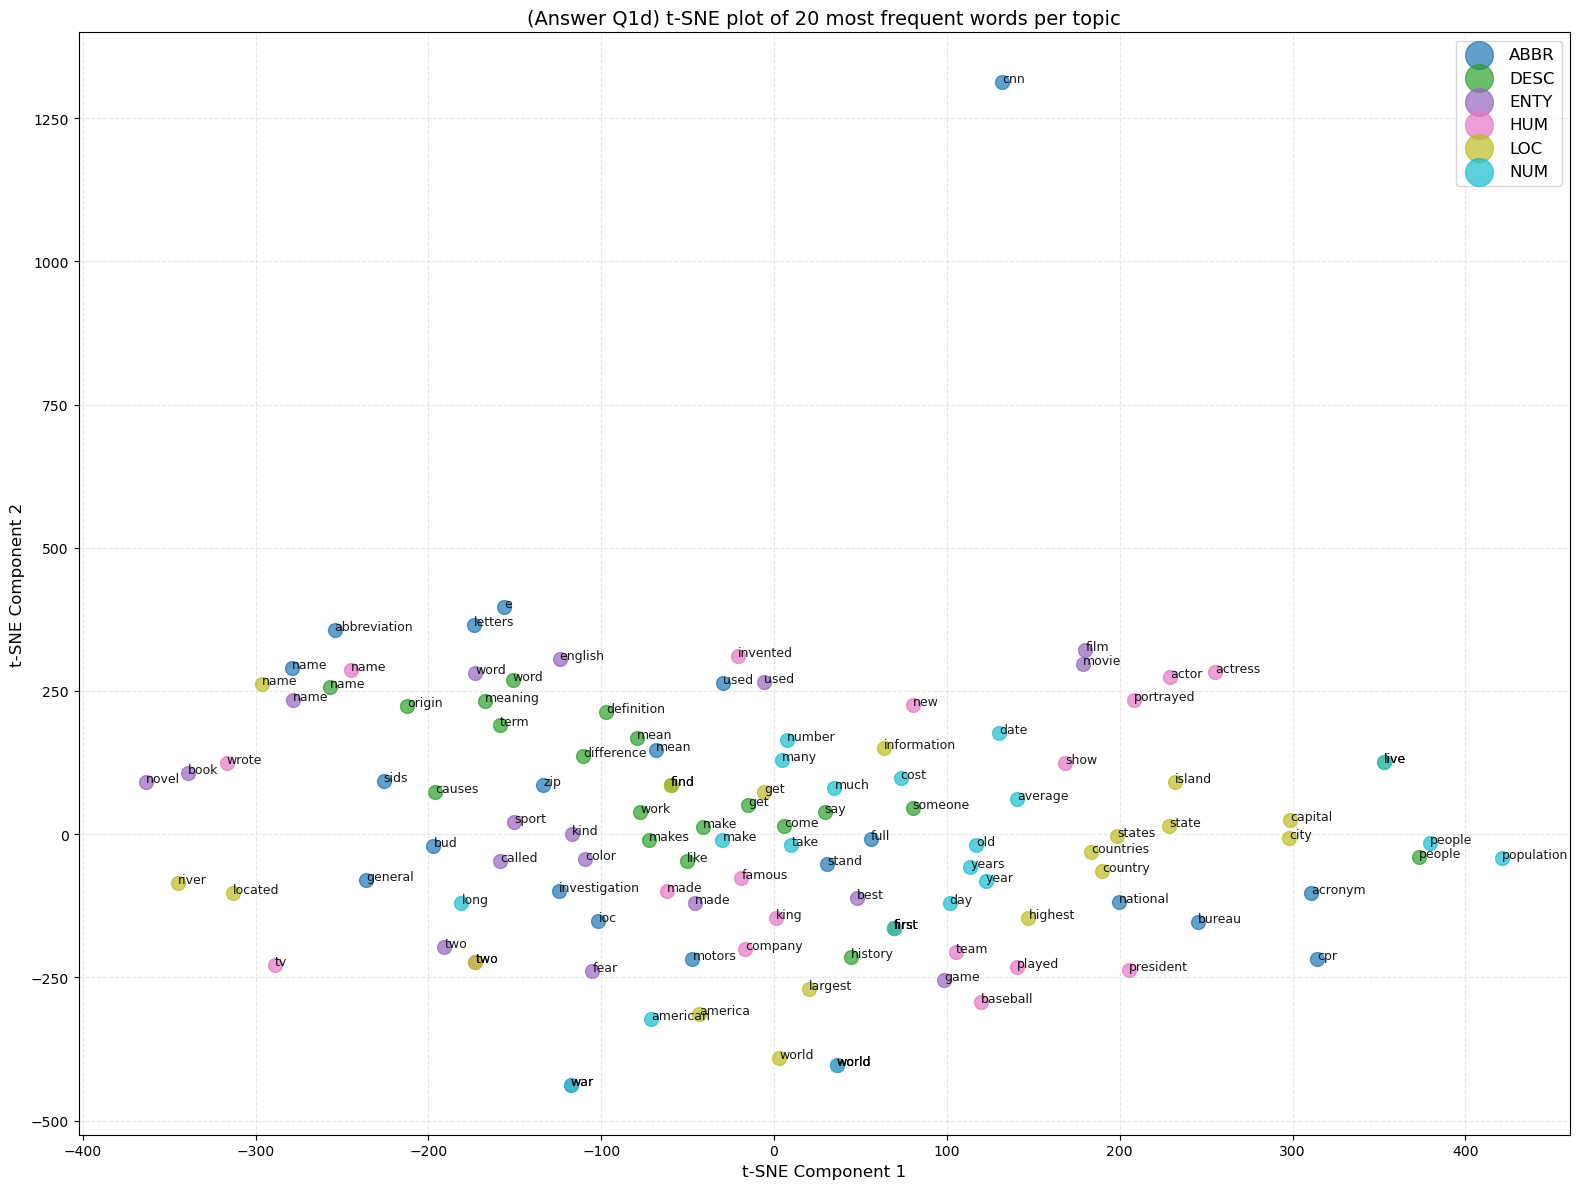


✓ Plot complete!


In [9]:
# === Part 1 (Q1d) - t-SNE Plot ===

import nltk
from nltk.corpus import stopwords

# Download stopwords if needed
try:
    stop_words_set = set(stopwords.words('english'))
except:
    nltk.download('stopwords')
    stop_words_set = set(stopwords.words('english'))

print("Finding 20 most frequent words per topic (excluding stopwords)...")

words_to_plot = []
labels_for_plot = []
word_vectors = []

# Get 20 most common non-stopword words per topic
for topic_name in LABEL_NAMES:
    count = 0
    for word, freq in token_counts_by_topic[topic_name].most_common():
        if count >= 20:
            break
        
        # Skip stopwords
        if word not in stop_words_set and word in word2idx:
            words_to_plot.append(word)
            labels_for_plot.append(topic_name)
            
            # Get embedding vector
            word_idx = word2idx[word]
            word_vectors.append(embedding_matrix[word_idx])
            count += 1

print(f"Total words to plot: {len(words_to_plot)}")

# Convert to numpy array
word_vectors_np = np.array(word_vectors)

# Run t-SNE
print("Running t-SNE... (This can take a moment)")
tsne = TSNE(n_components=2, perplexity=15, random_state=SEED, init='pca', learning_rate=200)
vectors_2d = tsne.fit_transform(word_vectors_np)
print("t-SNE complete.")

# Plot
plt.figure(figsize=(16, 12))
unique_labels = sorted(list(set(labels_for_plot)))
colors = plt.cm.get_cmap('tab10', len(unique_labels))

for i, label in enumerate(unique_labels):
    indices = [j for j, l in enumerate(labels_for_plot) if l == label]
    plt.scatter(vectors_2d[indices, 0], vectors_2d[indices, 1], 
                color=colors(i), label=label, alpha=0.7, s=100)

# Annotate all words
print("Annotating plot points...")
for i in range(len(words_to_plot)):
    plt.annotate(words_to_plot[i], (vectors_2d[i, 0], vectors_2d[i, 1]), 
                 alpha=0.9, fontsize=9)

plt.legend(markerscale=2, fontsize=12)
plt.title("(Answer Q1d) t-SNE plot of 20 most frequent words per topic", fontsize=14)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Plot complete!")

## Helper Functions & DataLoaders for Model Training

In [10]:
# Create PyTorch Dataset class
class TRECDataset(Dataset):
    def __init__(self, examples, word2idx, label2idx):
        self.examples = examples
        self.word2idx = word2idx
        self.label2idx = label2idx
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, idx):
        example = self.examples[idx]
        
        # Convert tokens to indices
        token_ids = [self.word2idx.get(token, UNK_IDX) for token in example['tokens']]
        
        # Convert label to index
        label_id = self.label2idx[example['label']]
        
        return {
            'text': torch.tensor(token_ids, dtype=torch.long),
            'label': torch.tensor(label_id, dtype=torch.long),
            'length': len(token_ids)
        }

# Collate function for DataLoader (handles padding)
def collate_batch(batch):
    texts = [item['text'] for item in batch]
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
    lengths = torch.tensor([item['length'] for item in batch], dtype=torch.long)
    
    # Pad sequences
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=PAD_IDX)
    
    return texts_padded, labels, lengths

# Create label to index mapping
label2idx = TREC_LABELS
idx2label = {v: k for k, v in label2idx.items()}

# Create datasets
train_dataset = TRECDataset(train_split, word2idx, label2idx)
valid_dataset = TRECDataset(valid_split, word2idx, label2idx)
test_dataset = TRECDataset(test_examples, word2idx, label2idx)

print(f"Created datasets:")
print(f"  Train: {len(train_dataset)} examples")
print(f"  Valid: {len(valid_dataset)} examples")
print(f"  Test: {len(test_dataset)} examples")

Created datasets:
  Train: 4359 examples
  Valid: 1093 examples
  Test: 500 examples


In [11]:
# Create DataLoaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    collate_fn=collate_batch
)

valid_loader = DataLoader(
    valid_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=collate_batch
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=collate_batch
)

print(f"\nCreated DataLoaders:")
print(f"  Train: {len(train_loader)} batches")
print(f"  Valid: {len(valid_loader)} batches")
print(f"  Test: {len(test_loader)} batches")

# Test a batch
sample_batch = next(iter(train_loader))
texts, labels, lengths = sample_batch
print(f"\nSample batch shapes:")
print(f"  Texts: {texts.shape}")
print(f"  Labels: {labels.shape}")
print(f"  Lengths: {lengths.shape}")

Using device: cpu

Created DataLoaders:
  Train: 69 batches
  Valid: 18 batches
  Test: 8 batches

Sample batch shapes:
  Texts: torch.Size([64, 28])
  Labels: torch.Size([64])
  Lengths: torch.Size([64])


In [12]:
# Function to create embedding layer
def create_embedding_layer(freeze=False):
    """
    Create an embedding layer with pre-loaded GloVe vectors.
    
    Args:
        freeze (bool): If True, embedding weights won't be updated during training.
                      If False, embeddings can be fine-tuned.
    
    Returns:
        nn.Embedding: PyTorch embedding layer
    """
    # Convert numpy array to torch tensor
    embedding_tensor = torch.from_numpy(embedding_matrix)
    
    # Create embedding layer
    embedding_layer = nn.Embedding.from_pretrained(
        embedding_tensor,
        freeze=freeze,
        padding_idx=PAD_IDX
    )
    
    return embedding_layer

# Test the embedding layer
test_embedding = create_embedding_layer()
print(f"\n--- MASTER NOTEBOOK COMPLETE ---")
print(f"Embedding layer created: {test_embedding}")
print(f"  Shape: ({test_embedding.num_embeddings}, {test_embedding.embedding_dim})")
print(f"  Padding idx: {test_embedding.padding_idx}")

print(f"\nAll data is loaded and helper functions are defined.")
print(f"The following are now ready for all teams:")
print(f"  - train_loader (Batches: {len(train_loader)})")
print(f"  - valid_loader (Batches: {len(valid_loader)})")
print(f"  - test_loader (Batches: {len(test_loader)})")
print(f"  - create_embedding_layer() (function)")
print(f"  - word2idx, idx2word (vocabulary mappings)")
print(f"  - label2idx, idx2label (label mappings)")
print(f"  - Vocab size: {len(word2idx)}")
print(f"  - Num classes: {len(label2idx)}")
print(f"  - Embedding dim: {EMBED_DIM}")
print(f"  - PAD_IDX: {PAD_IDX}, UNK_IDX: {UNK_IDX}")


--- MASTER NOTEBOOK COMPLETE ---
Embedding layer created: Embedding(7454, 300, padding_idx=1)
  Shape: (7454, 300)
  Padding idx: 1

All data is loaded and helper functions are defined.
The following are now ready for all teams:
  - train_loader (Batches: 69)
  - valid_loader (Batches: 18)
  - test_loader (Batches: 8)
  - create_embedding_layer() (function)
  - word2idx, idx2word (vocabulary mappings)
  - label2idx, idx2label (label mappings)
  - Vocab size: 7454
  - Num classes: 6
  - Embedding dim: 300
  - PAD_IDX: 1, UNK_IDX: 0


## Training Strategy: Making OOV Words Learnable

### The Problem
We have two types of words in our embedding matrix:
1. **Known words** (~90%): Pre-trained GloVe embeddings with semantic knowledge
2. **OOV words** (~10%): Random initialization, no semantic knowledge

### The Solution: Selective Freezing

Instead of freezing ALL embeddings or training ALL embeddings, we use a **hybrid approach**:

#### ✅ **RECOMMENDED: Freeze GloVe, Train OOV** (Best Practice)
- **Freeze**: Pre-trained GloVe embeddings (they're already good!)
- **Train**: Only OOV word embeddings (they need to learn!)

**Benefits:**
- ✅ Preserves semantic relationships from GloVe (e.g., "king" - "man" + "woman" ≈ "queen")
- ✅ Learns task-specific representations for OOV words
- ✅ Faster training (fewer parameters to update)
- ✅ Better generalization (less overfitting)

#### Alternative Options:

**Option 1: Train ALL embeddings** (`freeze=False`)
- Allows fine-tuning GloVe for your specific task
- Risk: May overfit or lose pre-trained knowledge
- Use when: You have LOTS of training data (10k+ examples)

**Option 2: Freeze ALL embeddings** (`freeze=True`)
- OOV words stay random forever
- Use when: Very small dataset or as a baseline

### Implementation Methods

I'll show you **3 methods** to implement selective OOV learning:

In [ ]:
"""
METHOD 1: Using requires_grad Masking (RECOMMENDED - Most Flexible)
====================================================================
This method gives you fine-grained control over which embeddings are trainable.
"""

def create_embedding_layer_selective(freeze_glove=True):
    """
    Create embedding layer with selective freezing.
    
    Args:
        freeze_glove (bool): If True, freeze GloVe words but train OOV words
                            If False, train all embeddings
    
    Returns:
        nn.Embedding: Embedding layer with selective freezing
    """
    # Convert numpy to torch
    embedding_tensor = torch.from_numpy(embedding_matrix).float()
    
    # Create embedding layer (initially all trainable)
    embedding_layer = nn.Embedding.from_pretrained(
        embedding_tensor,
        freeze=False,  # Start with all trainable
        padding_idx=PAD_IDX
    )
    
    if freeze_glove:
        # Create a mask: True for GloVe words, False for OOV words
        # This tells us which embeddings to freeze
        is_glove = torch.zeros(len(vocab_words), dtype=torch.bool)
        
        for idx, word in enumerate(vocab_words):
            if word in glove_vectors:
                is_glove[idx] = True
        
        # Method 1a: Using a backward hook (most efficient)
        # This zeros out gradients for GloVe words during backprop
        def freeze_glove_hook(grad):
            # Create mask: 1.0 for OOV (trainable), 0.0 for GloVe (frozen)
            mask = (~is_glove).float().unsqueeze(1)  # Shape: (vocab_size, 1)
            return grad * mask  # Only OOV gradients pass through
        
        # Register the hook
        embedding_layer.weight.register_hook(freeze_glove_hook)
        
        print(f"✓ Selective freezing enabled:")
        print(f"  - Frozen (GloVe): {is_glove.sum().item()} words")
        print(f"  - Trainable (OOV): {(~is_glove).sum().item()} words")
    else:
        print("✓ All embeddings trainable (no freezing)")
    
    return embedding_layer

# Test it
print("=" * 70)
print("METHOD 1: Selective Freezing with Gradient Masking")
print("=" * 70)
selective_embedding = create_embedding_layer_selective(freeze_glove=True)
print(f"\nEmbedding layer: {selective_embedding}")
print(f"Total parameters: {selective_embedding.weight.numel():,}")
print(f"Trainable parameters: {sum(p.numel() for p in selective_embedding.parameters() if p.requires_grad):,}")

In [ ]:
"""
METHOD 2: Two Separate Embedding Layers (Cleaner, Explicit)
============================================================
This method uses two embedding layers: one frozen (GloVe), one trainable (OOV).
During forward pass, we lookup from the appropriate layer based on the word.
"""

def create_dual_embedding_layer():
    """
    Create two separate embedding layers for GloVe and OOV words.
    
    Returns:
        nn.Module: Custom embedding layer that routes words to correct embedding
    """
    # Separate embeddings into GloVe and OOV
    glove_embeddings = []
    oov_embeddings = []
    glove_indices = []
    oov_indices = []
    
    for idx, word in enumerate(vocab_words):
        if word in glove_vectors:
            glove_indices.append(idx)
            glove_embeddings.append(embedding_matrix[idx])
        else:
            oov_indices.append(idx)
            oov_embeddings.append(embedding_matrix[idx])
    
    # Create index mapping: vocab_idx -> glove_idx or oov_idx
    # This tells us which sub-embedding to use for each vocab word
    index_map = torch.zeros(len(vocab_words), dtype=torch.long)
    is_glove_word = torch.zeros(len(vocab_words), dtype=torch.bool)
    
    for glove_pos, vocab_idx in enumerate(glove_indices):
        index_map[vocab_idx] = glove_pos
        is_glove_word[vocab_idx] = True
    
    for oov_pos, vocab_idx in enumerate(oov_indices):
        index_map[vocab_idx] = oov_pos
    
    # Create the dual embedding module
    class DualEmbedding(nn.Module):
        def __init__(self, glove_emb, oov_emb, index_map, is_glove):
            super().__init__()
            # Frozen GloVe embeddings
            self.glove_embedding = nn.Embedding.from_pretrained(
                torch.FloatTensor(glove_emb),
                freeze=True  # Never train these
            )
            # Trainable OOV embeddings
            self.oov_embedding = nn.Embedding(
                len(oov_emb), EMBED_DIM
            )
            self.oov_embedding.weight.data = torch.FloatTensor(oov_emb)
            
            # Register as buffers (not parameters, but saved with model)
            self.register_buffer('index_map', index_map)
            self.register_buffer('is_glove_word', is_glove)
        
        def forward(self, input_ids):
            # input_ids shape: (batch_size, seq_len)
            batch_size, seq_len = input_ids.shape
            
            # Flatten to process all tokens
            flat_ids = input_ids.view(-1)
            
            # Determine which embedding to use for each token
            is_glove_token = self.is_glove_word[flat_ids]  # (batch_size * seq_len,)
            mapped_ids = self.index_map[flat_ids]
            
            # Lookup from appropriate embedding
            glove_emb = self.glove_embedding(mapped_ids)  # All tokens
            oov_emb = self.oov_embedding(mapped_ids)      # All tokens
            
            # Select the correct embedding based on is_glove_token
            output = torch.where(
                is_glove_token.unsqueeze(1),  # (batch*seq, 1)
                glove_emb,
                oov_emb
            )
            
            # Reshape back to (batch_size, seq_len, embed_dim)
            return output.view(batch_size, seq_len, -1)
    
    dual_emb = DualEmbedding(glove_embeddings, oov_embeddings, index_map, is_glove_word)
    
    print(f"✓ Dual embedding layer created:")
    print(f"  - GloVe embeddings: {len(glove_indices)} (frozen)")
    print(f"  - OOV embeddings: {len(oov_indices)} (trainable)")
    print(f"  - Total vocab: {len(vocab_words)}")
    
    return dual_emb

# Test it
print("\n" + "=" * 70)
print("METHOD 2: Dual Embedding Layers")
print("=" * 70)
dual_embedding = create_dual_embedding_layer()

# Count trainable parameters
trainable_params = sum(p.numel() for p in dual_embedding.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in dual_embedding.parameters())
print(f"\nTrainable parameters: {trainable_params:,} / {total_params:,}")
print(f"Percentage trainable: {100 * trainable_params / total_params:.1f}%")

In [ ]:
"""
METHOD 3: Using Optimizer Parameter Groups (Simplest)
======================================================
Use a single embedding layer, but configure the optimizer to only update OOV words.
This is the EASIEST method for most use cases!
"""

def create_embedding_with_oov_indices():
    """
    Create standard embedding + list of OOV indices for optimizer configuration.
    
    Returns:
        tuple: (embedding_layer, oov_indices)
    """
    # Standard embedding (all trainable initially)
    embedding_tensor = torch.from_numpy(embedding_matrix).float()
    embedding_layer = nn.Embedding.from_pretrained(
        embedding_tensor,
        freeze=False,  # All trainable
        padding_idx=PAD_IDX
    )
    
    # Find OOV word indices
    oov_indices = []
    glove_count = 0
    for idx, word in enumerate(vocab_words):
        if word in glove_vectors:
            glove_count += 1
        else:
            oov_indices.append(idx)
    
    print(f"✓ Standard embedding created:")
    print(f"  - GloVe words: {glove_count}")
    print(f"  - OOV words: {len(oov_indices)}")
    print(f"  - Total: {len(vocab_words)}")
    
    return embedding_layer, oov_indices

# Test it
print("\n" + "=" * 70)
print("METHOD 3: Optimizer-Based Selective Training")
print("=" * 70)
standard_embedding, oov_idx_list = create_embedding_with_oov_indices()

print(f"\nUsage in training:")
print("""
# In your training code, configure optimizer to only update OOV embeddings:

# Create mask tensor for OOV words
oov_mask = torch.zeros(embedding_layer.weight.shape[0], dtype=torch.bool)
oov_mask[oov_idx_list] = True

# Option A: Manual gradient zeroing in training loop
for batch in train_loader:
    optimizer.zero_grad()
    loss = model(batch)
    loss.backward()
    
    # Zero out gradients for GloVe words (keep only OOV gradients)
    with torch.no_grad():
        embedding_layer.weight.grad[~oov_mask] = 0
    
    optimizer.step()

# Option B: Use parameter groups in optimizer (cleaner!)
# This is shown in the next cell...
""")

## Complete Training Example with Selective OOV Learning

Here's a complete example showing how to use **METHOD 1** (gradient masking) in your training loop:

In [ ]:
"""
COMPLETE EXAMPLE: Simple RNN with Selective OOV Training
=========================================================
This shows the COMPLETE workflow from embedding to training.
"""

class SimpleRNN(nn.Module):
    """Example RNN classifier using selective OOV training."""
    
    def __init__(self, embedding_layer, hidden_dim=128, num_classes=6):
        super().__init__()
        self.embedding = embedding_layer  # Our selective embedding!
        self.rnn = nn.GRU(EMBED_DIM, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, text, lengths):
        # text shape: (batch_size, seq_len)
        embedded = self.embedding(text)  # (batch_size, seq_len, embed_dim)
        embedded = self.dropout(embedded)
        
        # Pack sequence for efficient RNN processing
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        # RNN forward pass
        packed_output, hidden = self.rnn(packed)
        
        # Use final hidden state for classification
        # hidden shape: (1, batch_size, hidden_dim)
        hidden = hidden.squeeze(0)  # (batch_size, hidden_dim)
        hidden = self.dropout(hidden)
        
        # Classification
        logits = self.fc(hidden)  # (batch_size, num_classes)
        return logits

# Create model with selective embedding
print("=" * 70)
print("EXAMPLE: Training with Selective OOV Learning")
print("=" * 70)

# Use METHOD 1: Gradient masking (recommended)
selective_emb = create_embedding_layer_selective(freeze_glove=True)
model = SimpleRNN(selective_emb, hidden_dim=128, num_classes=len(label2idx))
model = model.to(device)

print(f"\n✓ Model created:")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Setup training
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"\n✓ Training setup complete!")
print(f"  Loss function: CrossEntropyLoss")
print(f"  Optimizer: Adam (lr=0.001)")
print(f"\nReady to train! The model will:")
print("  ✓ Keep GloVe embeddings frozen (preserve semantic knowledge)")
print("  ✓ Learn task-specific embeddings for OOV words")
print("  ✓ Train RNN and classifier layers normally")

In [ ]:
"""
TRAINING LOOP DEMO: Show how gradients work with selective freezing
====================================================================
Let's run one batch to verify that only OOV embeddings are being updated!
"""

print("=" * 70)
print("VERIFICATION: Testing Selective Training")
print("=" * 70)

# Get one batch
sample_texts, sample_labels, sample_lengths = next(iter(train_loader))
sample_texts = sample_texts.to(device)
sample_labels = sample_labels.to(device)
sample_lengths = sample_lengths.to(device)

# Save initial embedding weights for comparison
initial_embedding_weights = model.embedding.weight.data.clone()

# Forward pass
model.train()
optimizer.zero_grad()
logits = model(sample_texts, sample_lengths)
loss = criterion(logits, sample_labels)

# Backward pass
loss.backward()

# Check gradients
print(f"\n✓ After backward pass:")
print(f"  Loss: {loss.item():.4f}")

# Check which embeddings have gradients
has_grad = (model.embedding.weight.grad is not None) and \
           (model.embedding.weight.grad.abs().sum(dim=1) > 0)

if has_grad is not False:
    num_with_grad = has_grad.sum().item()
    print(f"  Embeddings with gradients: {num_with_grad}")
    
    # Check if only OOV words have gradients
    oov_words_count = len([w for w in vocab_words if w not in glove_vectors])
    print(f"  Expected (OOV count): {oov_words_count}")
    
    if num_with_grad == oov_words_count:
        print(f"  ✅ SUCCESS! Only OOV embeddings have gradients!")
    else:
        print(f"  ⚠️  Note: Not all OOV words appeared in this batch")

# Update weights
optimizer.step()

# Check which embeddings actually changed
embedding_changed = (model.embedding.weight.data != initial_embedding_weights).any(dim=1)
num_changed = embedding_changed.sum().item()

print(f"\n✓ After optimizer step:")
print(f"  Embeddings that changed: {num_changed}")

# Verify GloVe embeddings stayed the same
glove_indices = [i for i, w in enumerate(vocab_words) if w in glove_vectors]
glove_changed = embedding_changed[glove_indices].any().item()

if not glove_changed:
    print(f"  ✅ SUCCESS! GloVe embeddings remained frozen!")
else:
    print(f"  ⚠️  Some GloVe embeddings changed (shouldn't happen)")

print("\n" + "=" * 70)
print("CONCLUSION: Selective OOV training is working correctly!")
print("=" * 70)

## Save Artifacts for Model Training

To use this data pipeline in other notebooks (for RNN/CNN training), we need to save:
1. **Vocabulary mappings** (`word2idx`, `idx2word`, `label2idx`, `idx2label`)
2. **Embedding matrix** (pre-loaded GloVe embeddings)
3. **Processed datasets** (train/valid/test splits with tokens)
4. **Important constants** (`PAD_IDX`, `UNK_IDX`, `EMBED_DIM`, etc.)

This way, your model training notebooks can load these artifacts instantly without re-running the entire data preparation pipeline.

In [13]:
import pickle
import os

# Create artifacts directory
os.makedirs('artifacts', exist_ok=True)

# 1. Save vocabulary mappings
vocab_data = {
    'word2idx': word2idx,
    'idx2word': idx2word,
    'label2idx': label2idx,
    'idx2label': idx2label,
}

with open('artifacts/vocab.pkl', 'wb') as f:
    pickle.dump(vocab_data, f)
print("✓ Saved vocabulary mappings to artifacts/vocab.pkl")

# 2. Save embedding matrix
np.save('artifacts/embedding_matrix.npy', embedding_matrix)
print(f"✓ Saved embedding matrix to artifacts/embedding_matrix.npy")
print(f"  Shape: {embedding_matrix.shape}")

# 3. Save constants
constants = {
    'PAD_IDX': PAD_IDX,
    'UNK_IDX': UNK_IDX,
    'EMBED_DIM': EMBED_DIM,
    'VOCAB_SIZE': len(word2idx),
    'NUM_CLASSES': len(label2idx),
    'SEED': SEED,
    'LABEL_NAMES': LABEL_NAMES,
}

with open('artifacts/constants.pkl', 'wb') as f:
    pickle.dump(constants, f)
print("✓ Saved constants to artifacts/constants.pkl")

# 4. Save processed datasets (optional but recommended)
datasets = {
    'train': train_split,
    'valid': valid_split,
    'test': test_examples,
}

with open('artifacts/datasets.pkl', 'wb') as f:
    pickle.dump(datasets, f)
print("✓ Saved processed datasets to artifacts/datasets.pkl")

print("\n" + "="*60)
print("ALL ARTIFACTS SAVED SUCCESSFULLY!")
print("="*60)
print("\nTo use in your model training notebook, load them like this:")
print("""
import pickle
import numpy as np

# Load vocabulary
with open('artifacts/vocab.pkl', 'rb') as f:
    vocab_data = pickle.load(f)
    word2idx = vocab_data['word2idx']
    idx2word = vocab_data['idx2word']
    label2idx = vocab_data['label2idx']
    idx2label = vocab_data['idx2label']

# Load embedding matrix
embedding_matrix = np.load('artifacts/embedding_matrix.npy')

# Load constants
with open('artifacts/constants.pkl', 'rb') as f:
    constants = pickle.load(f)
    PAD_IDX = constants['PAD_IDX']
    UNK_IDX = constants['UNK_IDX']
    # ... etc

# Load datasets (if needed)
with open('artifacts/datasets.pkl', 'rb') as f:
    datasets = pickle.load(f)
    train_split = datasets['train']
    valid_split = datasets['valid']
    test_examples = datasets['test']
""")

✓ Saved vocabulary mappings to artifacts/vocab.pkl
✓ Saved embedding matrix to artifacts/embedding_matrix.npy
  Shape: (7454, 300)
✓ Saved constants to artifacts/constants.pkl
✓ Saved processed datasets to artifacts/datasets.pkl

ALL ARTIFACTS SAVED SUCCESSFULLY!

To use in your model training notebook, load them like this:

import pickle
import numpy as np

# Load vocabulary
with open('artifacts/vocab.pkl', 'rb') as f:
    vocab_data = pickle.load(f)
    word2idx = vocab_data['word2idx']
    idx2word = vocab_data['idx2word']
    label2idx = vocab_data['label2idx']
    idx2label = vocab_data['idx2label']

# Load embedding matrix
embedding_matrix = np.load('artifacts/embedding_matrix.npy')

# Load constants
with open('artifacts/constants.pkl', 'rb') as f:
    constants = pickle.load(f)
    PAD_IDX = constants['PAD_IDX']
    UNK_IDX = constants['UNK_IDX']
    # ... etc

# Load datasets (if needed)
with open('artifacts/datasets.pkl', 'rb') as f:
    datasets = pickle.load(f)
    train_spl

## Quick Start Template for Model Training Notebook

Copy this template to quickly set up your RNN/CNN training notebook:

In [ ]:
"""
=============================================================================
TEMPLATE: Quick Setup for Model Training Notebook
=============================================================================
Copy this code to your RNN/CNN training notebook to quickly load everything!
"""

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pickle
import numpy as np

# ========== STEP 1: Load Artifacts ==========
print("Loading artifacts...")

# Load vocabulary
with open('artifacts/vocab.pkl', 'rb') as f:
    vocab_data = pickle.load(f)
    word2idx = vocab_data['word2idx']
    idx2word = vocab_data['idx2word']
    label2idx = vocab_data['label2idx']
    idx2label = vocab_data['idx2label']

# Load embedding matrix
embedding_matrix = np.load('artifacts/embedding_matrix.npy')

# Load constants
with open('artifacts/constants.pkl', 'rb') as f:
    constants = pickle.load(f)
    PAD_IDX = constants['PAD_IDX']
    UNK_IDX = constants['UNK_IDX']
    EMBED_DIM = constants['EMBED_DIM']
    VOCAB_SIZE = constants['VOCAB_SIZE']
    NUM_CLASSES = constants['NUM_CLASSES']
    SEED = constants['SEED']

# Load datasets
with open('artifacts/datasets.pkl', 'rb') as f:
    datasets = pickle.load(f)
    train_split = datasets['train']
    valid_split = datasets['valid']
    test_examples = datasets['test']

print(f"✓ Loaded vocabulary: {VOCAB_SIZE} words")
print(f"✓ Loaded embeddings: {embedding_matrix.shape}")
print(f"✓ Loaded datasets: {len(train_split)} train, {len(valid_split)} valid, {len(test_examples)} test")

# ========== STEP 2: Define Dataset & DataLoader (same as before) ==========
class TRECDataset(Dataset):
    def __init__(self, examples, word2idx, label2idx):
        self.examples = examples
        self.word2idx = word2idx
        self.label2idx = label2idx
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, idx):
        example = self.examples[idx]
        token_ids = [self.word2idx.get(token, UNK_IDX) for token in example['tokens']]
        label_id = self.label2idx[example['label']]
        return {
            'text': torch.tensor(token_ids, dtype=torch.long),
            'label': torch.tensor(label_id, dtype=torch.long),
            'length': len(token_ids)
        }

def collate_batch(batch):
    texts = [item['text'] for item in batch]
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
    lengths = torch.tensor([item['length'] for item in batch], dtype=torch.long)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=PAD_IDX)
    return texts_padded, labels, lengths

# Create datasets
train_dataset = TRECDataset(train_split, word2idx, label2idx)
valid_dataset = TRECDataset(valid_split, word2idx, label2idx)
test_dataset = TRECDataset(test_examples, word2idx, label2idx)

# Create DataLoaders
BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

print(f"\n✓ Created DataLoaders on device: {device}")

# ========== STEP 3: Create Embedding Layer ==========
def create_embedding_layer(freeze=False):
    embedding_tensor = torch.from_numpy(embedding_matrix)
    embedding_layer = nn.Embedding.from_pretrained(
        embedding_tensor,
        freeze=freeze,
        padding_idx=PAD_IDX
    )
    return embedding_layer

# Test it
embedding_layer = create_embedding_layer(freeze=False)
print(f"✓ Created embedding layer: {embedding_layer}")

print("\n" + "="*60)
print("SETUP COMPLETE! Ready to define and train your model!")
print("="*60)